In [12]:
from medmnist import PneumoniaMNIST
from medmnist import INFO

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl
from pennylane.qnn import TorchLayer

In [13]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [14]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [15]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [16]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [17]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [18]:
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)
train_raw_loader, train_raw_dataset, val_raw_loader, val_raw_dataset, test_raw_loader, test_raw_dataset = load_data(batch_size=32, train_fraction=1)

In [19]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_raw_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_raw_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_raw_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_raw_loader)

In [20]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


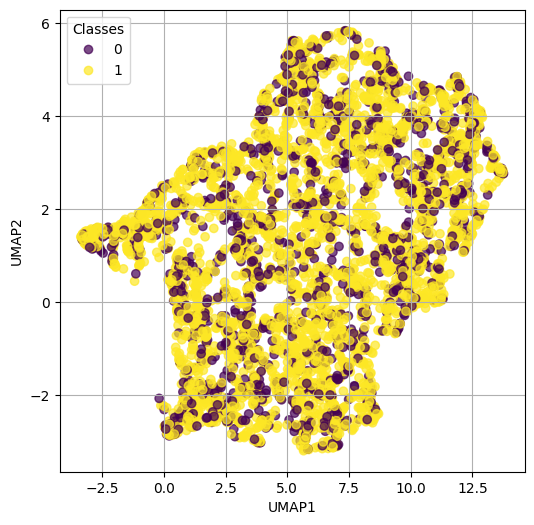

In [21]:
y_train = torch.cat([y for _, y in train_raw_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


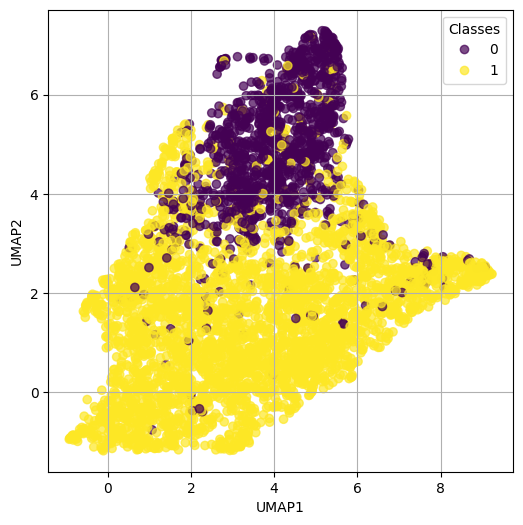

In [22]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_raw_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

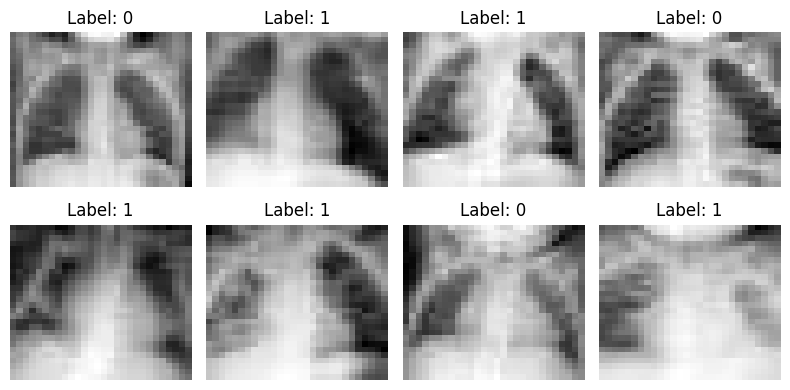

In [23]:
#original images
x_batch, y_batch = sample_batch(train_raw_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_15928/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


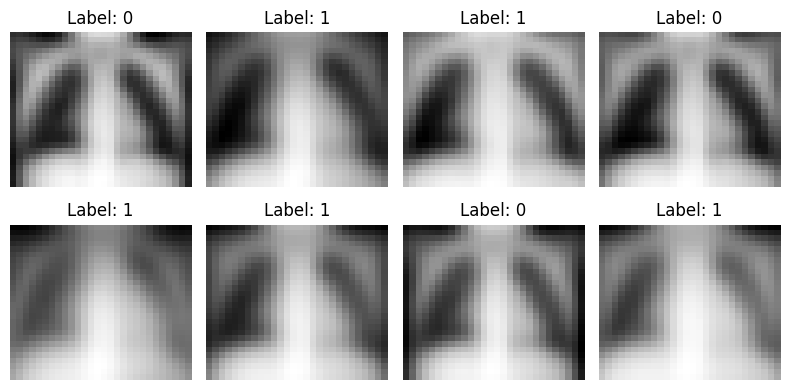

In [24]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

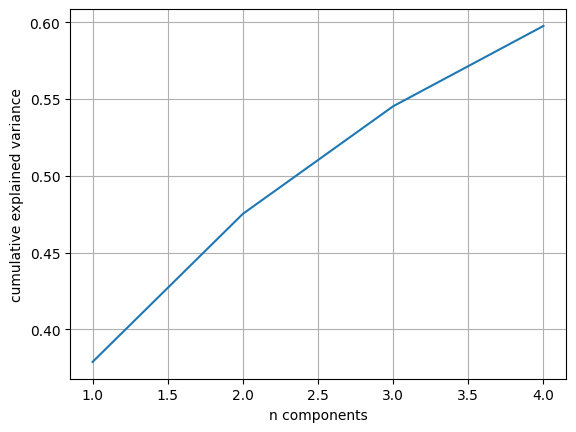

In [25]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

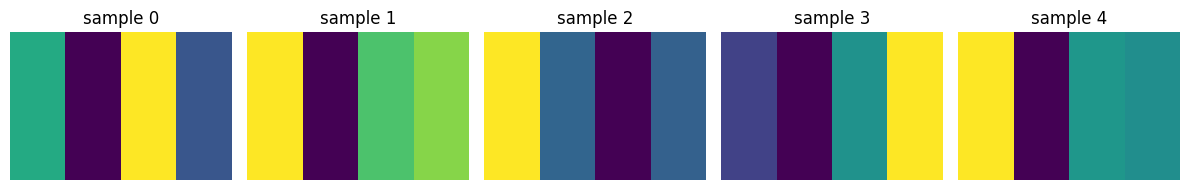

In [26]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [28]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


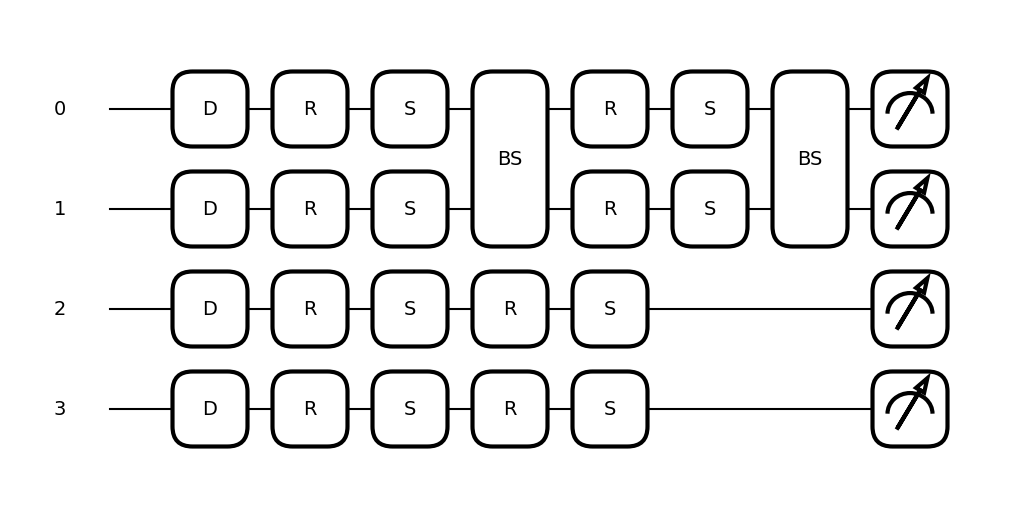

In [29]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train_scaled = scaler.fit_transform(x_train_encoded)
# x_val_scaled = scaler.fit_transform(x_val_encoded)
# x_test_scaled = scaler.fit_transform(x_test_encoded)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.transform(x_val_encoded)
x_test_scaled = scaler.transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [31]:
print(x_train_tensor[0])

tensor([ 0.3155, -0.2293,  1.3783,  0.1973])


In [32]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [33]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [34]:
print(output)

tensor([ 0.3147, -1.5155, -0.9393,  0.0399], dtype=torch.float64)


In [35]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

    def get_quantum_features(self, x):
        with torch.no_grad():
            return torch.stack([self.quantum(sample) for sample in x])

In [37]:
class QuantumLinear(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)

        self.head = nn.Sequential(
            nn.Linear(n_qumodes, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [38]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.head(x)

In [39]:
# def train_v2(model, dataloader, optimizer, loss_fn, device, results_path, model_path):
def train_v2(model, dataloader, optimizer, loss_fn, device):

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    model.train()

    total_loss = 0
    total_samples = 0
    correct = 0
    all_labels = []
    all_preds = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)
        loss.backward()

        # for name, param in model.named_parameters():
        #     print(f"{name:30s} requires_grad={param.requires_grad} | grad={param.grad}")
        # break
        
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}",
        })

        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics

In [40]:
# def train(model, dataloader, optimizer, loss_fn, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     for x_batch, y_batch in progress_bar:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         # print(x_batch.shape)
#         optimizer.zero_grad()
#         logits = model(x_batch)
#         y_batch = y_batch.view(-1).long()
#         # print(logits.shape)
#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x_batch.size(0)
#         pred = logits.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()
#         total_samples += x_batch.size(0)

#         progress_bar.set_postfix({
#             "loss": f"{loss.item():.4f}",
#             "acc": f"{(correct/total_samples):.4f}"
#         })

#     avg_loss = total_loss / total_samples
#     avg_acc = correct / total_samples
#     return avg_loss, avg_acc

In [41]:
def evaluate_v2(model, dataloader, loss_fn, device):
    model.eval()

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    all_probs = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = recall_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics, all_preds, all_probs, all_labels
    

In [42]:
from sklearn.model_selection import StratifiedKFold

def run_kfold_training(model_class, dataset, optimizer, criterion, model_save_name=False, classical=False, k=5, num_epochs=10, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    labels = np.array([label for _, label in dataset])

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n Fold {fold+1}/{k}")

        all_train_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        all_val_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

        if classical:
            # model = ClassicalModel().to(device)
            model = model_class().to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        elif model_save_name:
            model = model_class(n_qumodes=4, n_classes=2).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        else:
            # model = QuantumWrapper().to(device)
            model = model_class(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            

        for epoch in range(num_epochs):
            # train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model_class, train_loader, optimizer, criterion, device)
            train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model, train_loader, optimizer, criterion, device)
            # val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model_class, val_loader, criterion, device)
            val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model, val_loader, criterion, device)



            all_train_metrics["acc"].append(train_acc)
            all_train_metrics["loss"].append(train_loss)
            all_train_metrics["prec"].append(train_prec)
            all_train_metrics["rec"].append(train_rec)
            all_train_metrics["f1"].append(train_f1)

            all_val_metrics["acc"].append(val_acc)
            all_val_metrics["loss"].append(val_loss)
            all_val_metrics["prec"].append(val_prec)
            all_val_metrics["rec"].append(val_rec)
            all_val_metrics["f1"].append(val_f1)

            tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
            tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

        if classical:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            # torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")
            torch.save(model.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")

        else:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_save_name}_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            # torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_best.pth")
            torch.save(model.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_save_name}_fold_{fold+1}_best.pth")

    # return all_train_metrics, all_val_metrics

In [43]:
def plot_metric_with_std(metric_name, train_folds, val_folds, epochs, classical=False, save_name=None):
    
    train_array = np.array(train_folds[metric_name])
    val_array = np.array(val_folds[metric_name])

    train_mean = np.mean(train_array, axis=0)
    train_std = np.std(train_array, axis=0)
    val_mean = np.mean(val_array, axis=0)
    val_std = np.std(val_array, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mean, label="Train", color="blue", marker="o")
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

    plt.plot(epochs, val_mean, label="Validation", color="green", marker="^")
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save_name:

        if classical:
            plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-" + save_name, dpi=300)
        else:
            plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/quantum-" + save_name, dpi=300)
    plt.show()

    return {
        "metric": metric_name,
        "train_name": float(train_mean[-1]),
        "train_std": float(train_std[-1]),
        "val_mean": float(val_mean[-1]),
        "val_std": float(val_std[-1]),
    }

In [44]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     with torch.no_grad():
#         for x_batch, y_batch in progress_bar:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(x_batch)
#             y_batch = y_batch.view(-1).long()
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)
#             pred = outputs.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()
#             total_samples += x_batch.size(0)

#             progress_bar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total_samples):.4f}"
#             })

#         avg_loss = total_loss / total_samples
#         avg_acc = correct / total_samples
#         return avg_loss, avg_acc

In [45]:
# epochs = 10
epochs = 30
device = "cpu"
# cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [46]:
from torchinfo import summary
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumLinear                            --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       10
│    └─Softmax: 2-2                      --
Total params: 42
Trainable params: 42
Non-trainable params: 0

In [47]:
cv_model.train()
for name, param in cv_model.named_parameters():
    print(f"{name} grad:", param.grad)
    print(f"{name} grad: requires_grad={param.requires_grad}")

quantum.weights grad: None
quantum.weights grad: requires_grad=True
head.0.weight grad: None
head.0.weight grad: requires_grad=True
head.0.bias grad: None
head.0.bias grad: requires_grad=True


In [48]:
quantum_weights = list(cv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[5.952439   3.2472098  2.0897744  1.8229902 ]
  [3.0685406  3.7962396  4.9646764  6.213889  ]
  [0.64282745 1.1881839  2.3944345  4.2383704 ]
  [2.9384665  5.317441   3.2752955  5.953903  ]]

 [[2.568897   2.6275315  1.6727604  1.1713468 ]
  [4.896602   3.6240304  3.3889232  3.6501572 ]
  [1.0245467  1.4870147  1.569268   1.7867888 ]
  [4.1154656  0.54941154 4.5100336  3.63635   ]]]


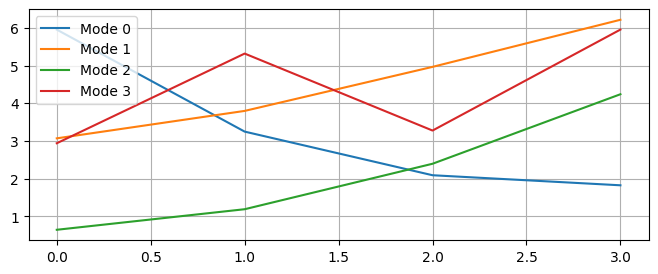

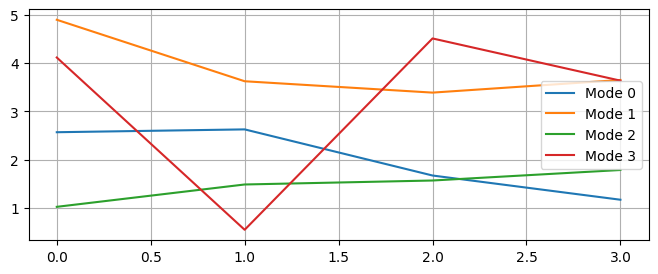

In [49]:
for layer in range(quantum_weights.shape[0]):
    plt.figure(figsize=(8, 3))
    for mode in range(quantum_weights.shape[1]):
        plt.plot(quantum_weights[layer, mode], label=f"Mode {mode}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [50]:
model_name = "linear"
# model_name = "chead"

In [ ]:
# run_kfold_training(cv_model, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=epochs, seed=42)

# run_kfold_training(QuantumWrapper, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=epochs, seed=42)

run_kfold_training(QuantumLinear, train_dataset, optimizer, criterion, model_name, classical=False, k=3, num_epochs=epochs, seed=42)

In [51]:
import pickle

In [52]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}



for fold in range(n_folds):
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
    
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        
    # with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

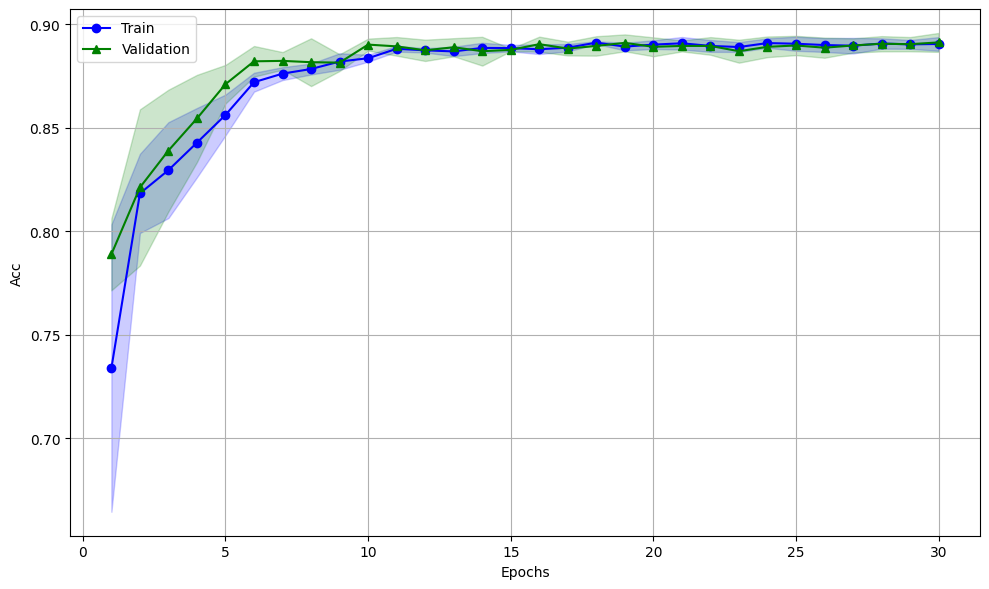

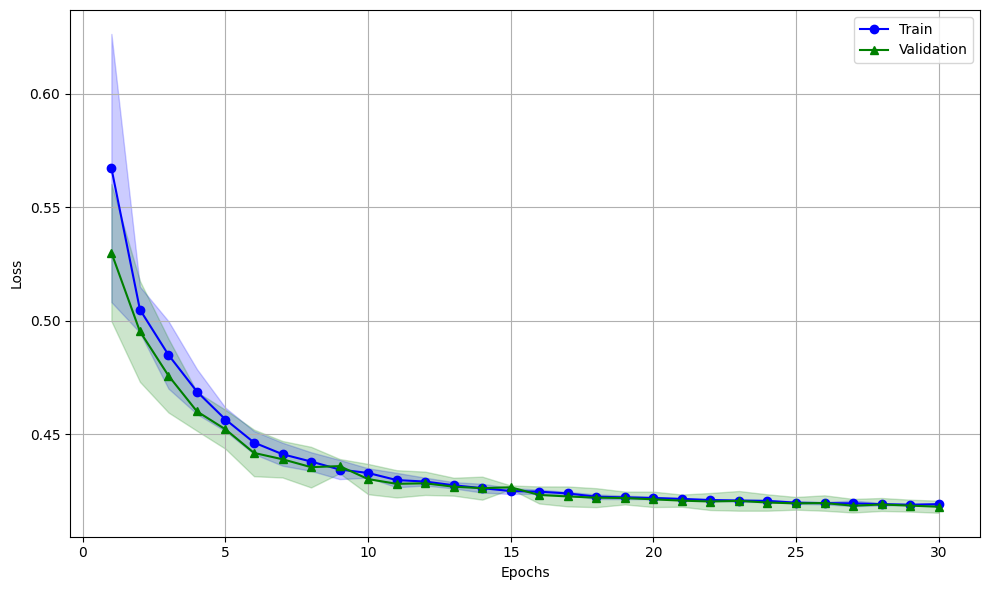

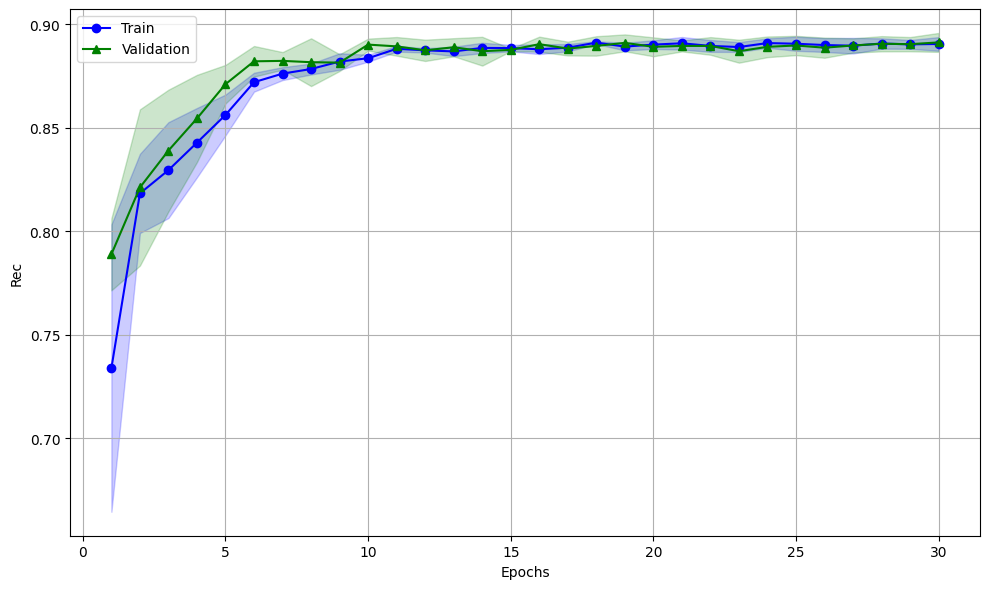

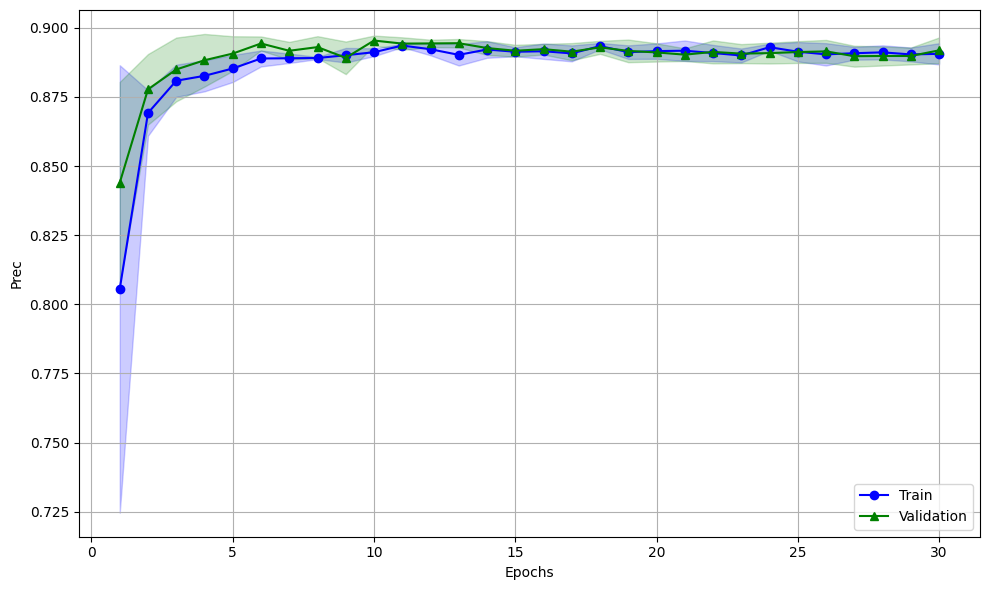

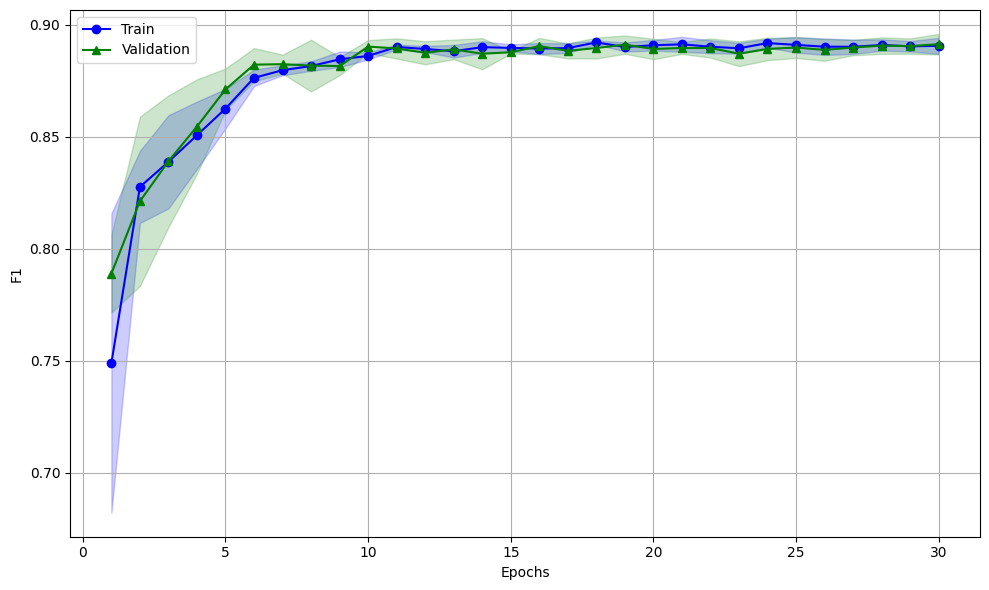

In [53]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range,  classical=False, save_name=f"{model_name}_mean_{metric}_curve")
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [54]:
# train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     train_loss, train_acc, train_prec, train_rec, train_f1, train_report = train_v2(cv_model, train_loader, optimizer, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, val_report, val_preds, val_probs, val_labels = evaluate_v2(cv_model, val_loader, criterion, device)

#     train_metrics["acc"].append(train_acc)
#     train_metrics["loss"].append(train_loss)
#     train_metrics["rec"].append(train_rec)
#     train_metrics["prec"].append(train_prec)
#     train_metrics["f1"].append(train_f1)
    
#     val_metrics["acc"].append(val_acc)
#     val_metrics["loss"].append(val_loss)
#     val_metrics["rec"].append(val_rec)
#     val_metrics["prec"].append(val_prec)
#     val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(cv_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth")
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

# import json
# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_train_metrics.json", "w") as f:
#     json.dump(train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_val_metrics.json", "w") as f:
#     json.dump(val_metrics, f, indent=4)

In [55]:
# epochs = range(1, len(train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [56]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 1 with val_f1 = 0.8975


In [57]:
device = "cpu"
# test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
test_cv_model = QuantumLinear(n_qumodes=4, n_classes=2).to(device)

# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
# test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{best_fold}_best.pth"))
test_cv_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_{model_name}_fold_{best_fold}_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████| 20/20 [00:02<00:00,  9.03it/s, loss=0.4597, acc=0.8526]

Test loss: 0.4597 | Test acc: 0.8526 | Test rec: 0.8526 | Test prec: 0.8520 | Test f1: 0.8526


In [58]:
for name, param in test_cv_model.quantum.named_parameters():
    print(name, param.data)

weights tensor([[[2.6128, 5.0837, 2.9640, 4.6581],
         [3.2254, 5.7607, 4.3248, 4.6632],
         [1.5705, 4.0255, 4.8180, 4.1889],
         [0.7199, 2.5560, 3.9663, 3.9060]],

        [[4.6118, 2.6358, 0.9559, 2.4208],
         [4.5434, 0.4360, 0.0910, 2.0006],
         [5.4306, 5.1340, 3.8524, 4.5457],
         [1.5768, 2.9904, 4.1007, 4.4483]]])


In [59]:
quantum_weights = list(test_cv_model.quantum.parameters())[0].detach().numpy()
print(quantum_weights.shape)
print(quantum_weights)

(2, 4, 4)
[[[2.6128411  5.0836606  2.9640086  4.6581116 ]
  [3.2253752  5.7607083  4.3247724  4.6632357 ]
  [1.570512   4.0254574  4.8180447  4.188851  ]
  [0.7199431  2.5559797  3.9663296  3.9059765 ]]

 [[4.611801   2.6358154  0.95588964 2.4207828 ]
  [4.5433755  0.43595257 0.0910303  2.0006206 ]
  [5.4305873  5.134039   3.852406   4.545691  ]
  [1.5768453  2.990444   4.100654   4.4482884 ]]]


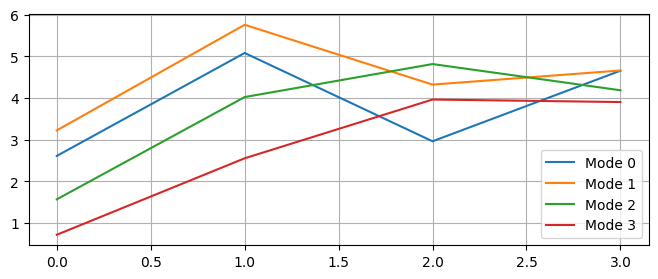

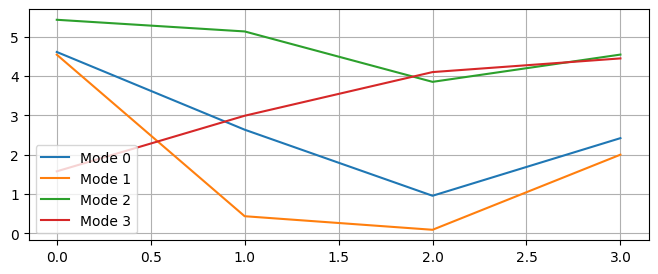

In [60]:
for layer in range(quantum_weights.shape[0]):
    plt.figure(figsize=(8, 3))
    for mode in range(quantum_weights.shape[1]):
        plt.plot(quantum_weights[layer, mode], label=f"Mode {mode}")
    plt.legend()
    plt.grid(True)
    plt.show()

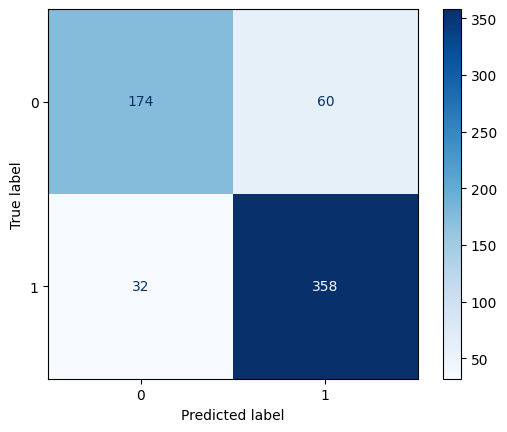

In [61]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cm", dpi=300)
plt.show()

AUROC: 0.91163708086785


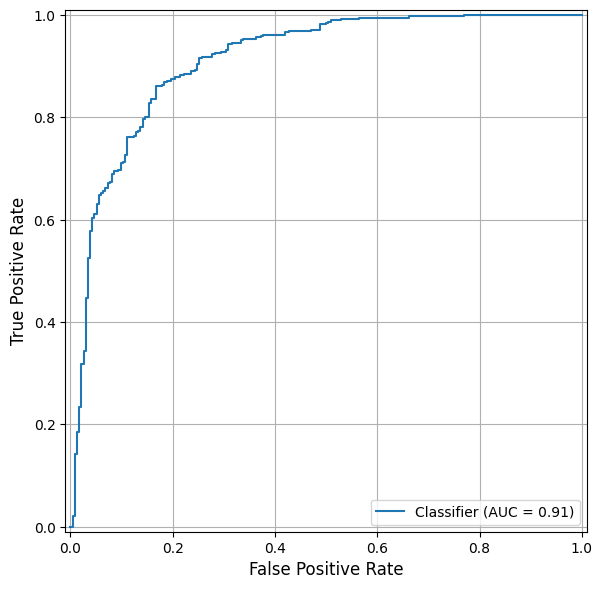

In [62]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)


auroc = roc_auc_score(all_labels_np, all_probs_np[:,1 ])
print("AUROC:", auroc)

fig, ax = plt.subplots(figsize=(8,6))
roc_disp = RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1], ax=ax)

ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-cv-auroc", dpi=300)
plt.show()
            
# auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
# print("AUROC:", auroc)

# RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
# plt.grid()
# plt.show()

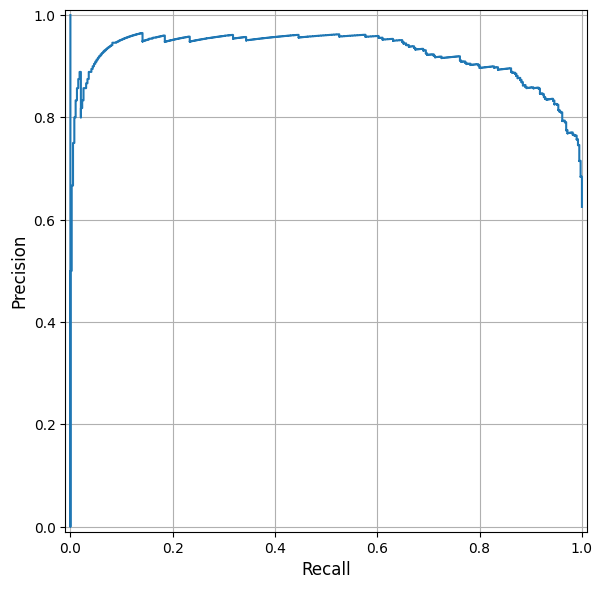

In [63]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)


fig, ax = plt.subplots(figsize=(8,6))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax)

# ax.set_title("Precision-Recall Curve", fontsize=14)
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig(f"/home/dalopezm/quantum-studies/quantum-cv/results/quantum-{model_name}-precision_recall_curve", dpi=300)
plt.show()


# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot()
# plt.grid(True)
# plt.show()

In [82]:
# def gradcam_quantum(model, input_tensor, class_idx=None):
#     model.eval()

#     input_tensor.requires_grad = True

#     quantum_features = torch.stack([model.quantum(sample) for sample in input_tensor])
#     quantum_features.retain_grad()

#     outputs = model.head(quantum_features)

#     if class_idx is None:
#         class_idx = outputs.argmax(dim=1)

#     scores = outputs[:, class_idx] if len(class_idx.shape) == 1 else outputs[0, class_idx]
#     scores.sum().backward()

#     gradients = quantum_features.grad
#     activations = quantum_features

#     weights = gradients.mean(dim=1, keepdim=True)
#     cam = weights * activations
#     # cam = cam.sum(dim=1)

#     return cam.detach().cpu(), outputs.detach().cpu(), class_idx.detach().cpu()

In [147]:
def gradcam_model(model, input_tensor, quantum=False, class_idx=None):
    model.eval()

    input_tensor.requires_grad = True

    if quantum:

        quantum_features = torch.stack([model.quantum(sample) for sample in input_tensor])
        quantum_features.retain_grad()
    
        outputs = model.head(quantum_features)
    
        if class_idx is None:
            class_idx = outputs.argmax(dim=1)
    
        scores = outputs[:, class_idx] if len(class_idx.shape) == 1 else outputs[0, class_idx]
        scores.sum().backward()
    
        gradients = quantum_features.grad
        activations = quantum_features

    else:
        activations = []
        gradients = []
        def forward_hook(module, input, output):
            activations.append(output.detach())

        def backward_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0].detach())

        target_layer = model.head[1]
        handle_fwd = target_layer.register_forward_hook(forward_hook)
        handle_bwd = target_layer.register_full_backward_hook(backward_hook)

        outputs = model(input_tensor)

        if class_idx is None:
            class_idx = outputs.argmax(dim=1)

        scores = outputs[range(len(outputs)), class_idx]
        scores.sum().backward()

        handle_fwd.remove()
        handle_bwd.remove()

        gradients = activations[0]
        activations = gradients[0]

    weights = gradients.mean(dim=1, keepdim=True)
    cam = weights * activations
    # cam = cam.sum(dim=1)

    return cam.detach().cpu(), outputs.detach().cpu(), class_idx.detach().cpu()

In [125]:
def plot_cam(cam, label="CAM Heatmap"):
    for i in range(cam.size(0)):
        plt.figure(figsize=(8,6))
        plt.bar(range(cam.size(1)), cam[i])
        plt.title(f"{label} - sample {i}")
        plt.xlabel("Qumode Index")
        plt.ylabel("Importance")
        plt.show()

In [126]:
# samples = x_test_tensor[0:8].to(device)
samples = x_test_tensor[0:16].to(device)
y_sample_labels = y_test_tensor[0:16].to(device)
print(samples.shape)

torch.Size([16, 4])


In [128]:
# cam, outputs, predictions = gradcam_quantum(test_cv_model, samples)
cam, outputs, predictions = gradcam_model(test_cv_model, samples, quantum=True)
print(cam.shape)


torch.Size([16, 4])


In [129]:
print(cam)

tensor([[ 2.4456e-01,  6.5923e-01, -2.7890e-03,  1.5847e-02],
        [ 3.3127e-02, -1.3508e-01,  1.3113e-03,  2.7473e-04],
        [-3.2287e+01,  2.5610e+01,  7.5435e-01, -8.4094e-01],
        [-1.6672e-02,  4.1295e-02, -1.9286e-04, -4.3056e-05],
        [ 3.3174e-02, -8.5446e-02, -4.0623e-04,  5.6047e-04],
        [ 2.7924e-02, -8.7082e-02,  5.9653e-05,  4.9714e-05],
        [ 5.9164e-01, -3.0879e+00, -1.2366e-02,  5.7069e-03],
        [ 2.9413e-02, -1.5041e-01, -1.0412e-04,  6.3065e-05],
        [ 3.7089e-02, -5.0443e-02,  5.8269e-04, -9.3271e-05],
        [-1.2035e+00,  3.0184e+00,  1.7120e-01, -5.5036e-02],
        [ 8.2579e-02, -3.2519e-02, -1.2580e-03,  2.2847e-03],
        [ 3.8149e-01,  1.3610e-01, -6.5155e-03,  1.4039e-02],
        [ 1.4626e-01, -1.4988e+00,  5.5075e-03,  3.3758e-03],
        [ 3.4747e-02, -1.0462e-01, -4.1121e-04,  7.9912e-05],
        [-2.2336e+01,  1.6716e+02, -1.8372e-02, -1.8473e+00],
        [ 6.5048e-01, -4.1403e+00,  5.6662e-03, -3.1566e-02]])


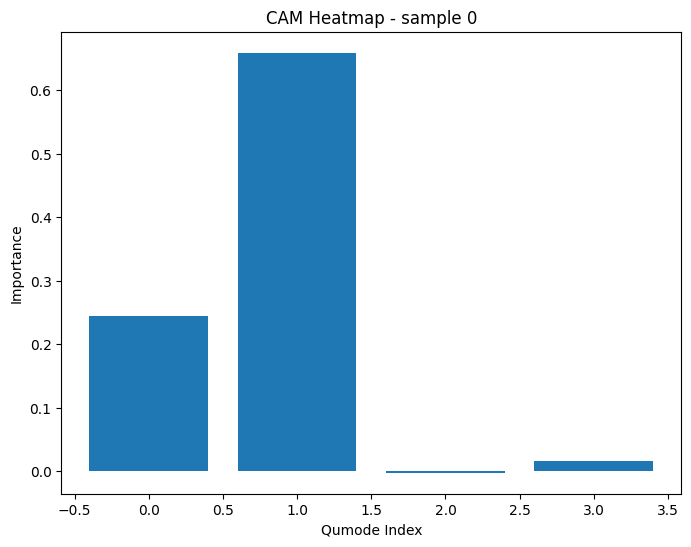

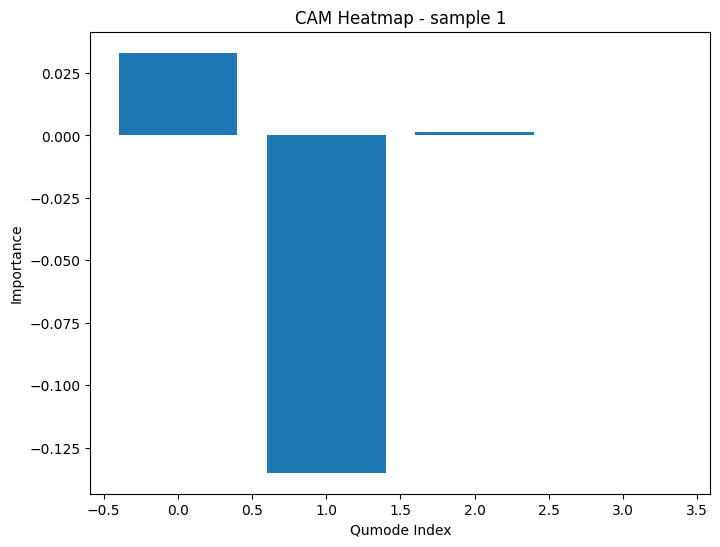

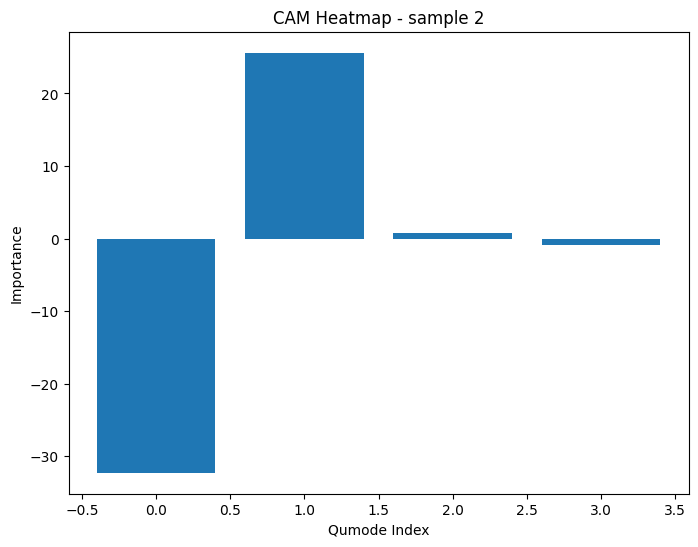

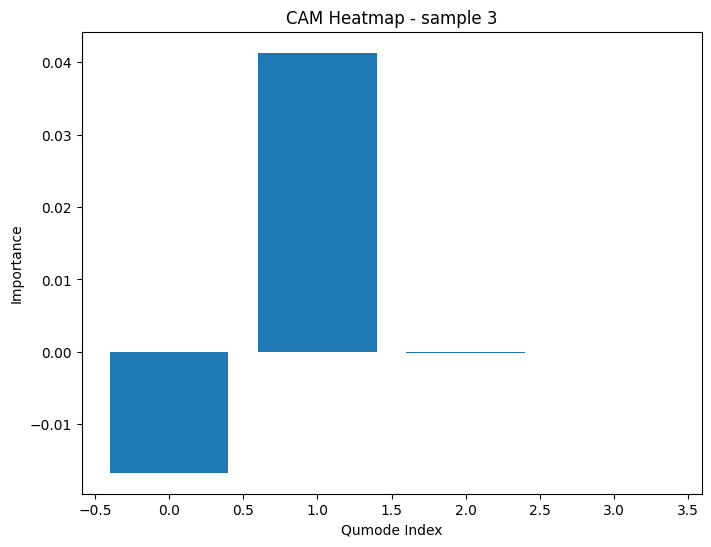

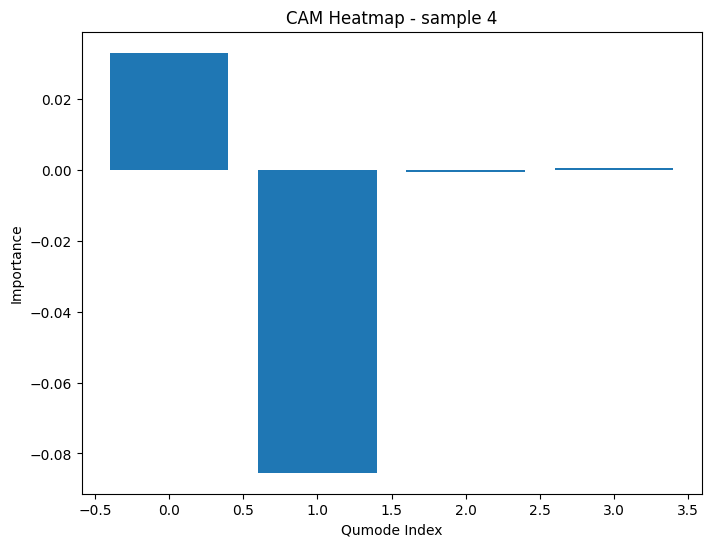

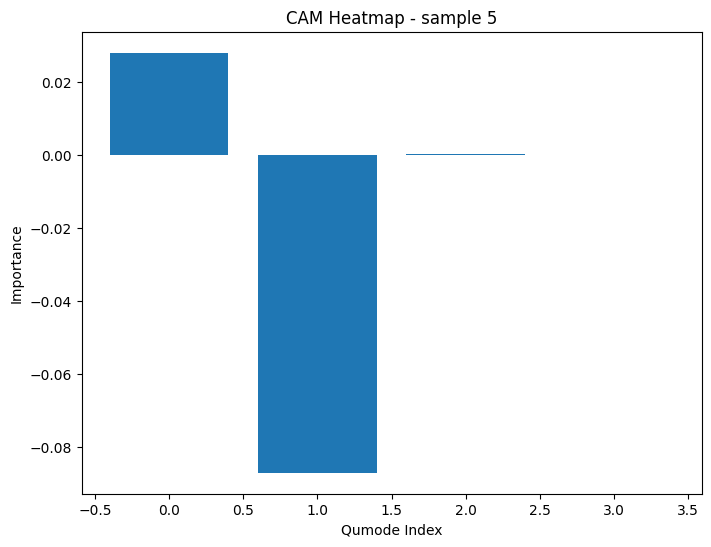

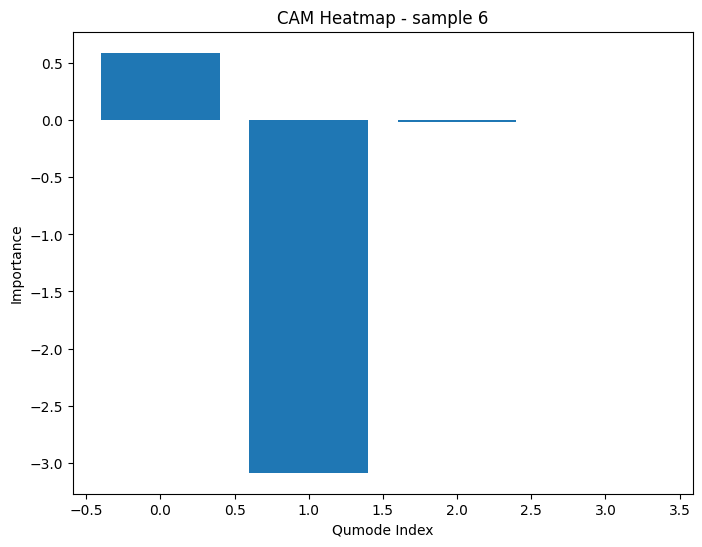

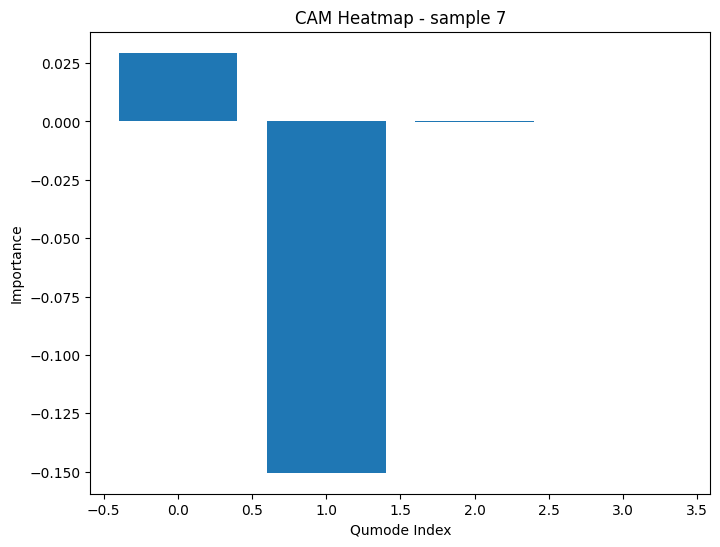

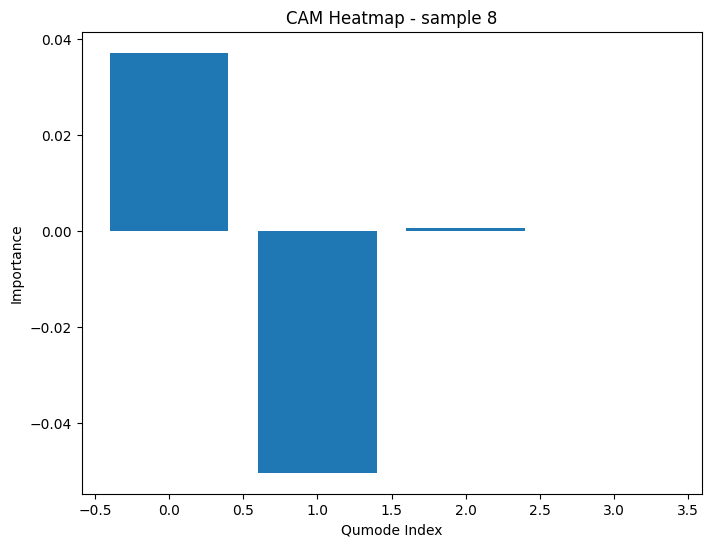

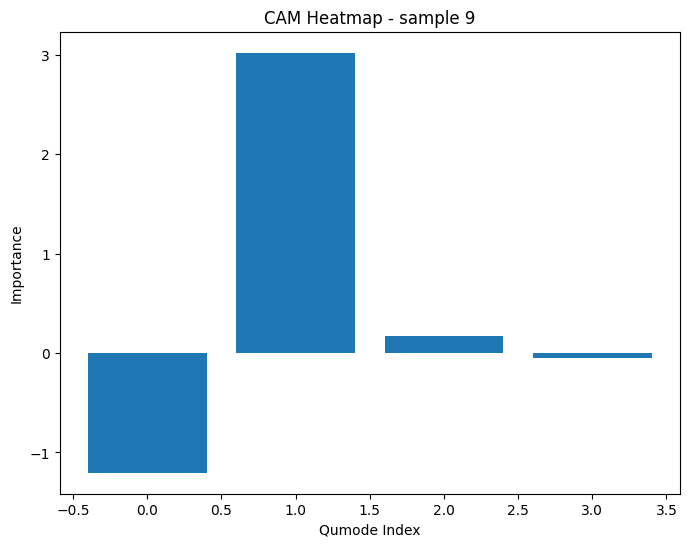

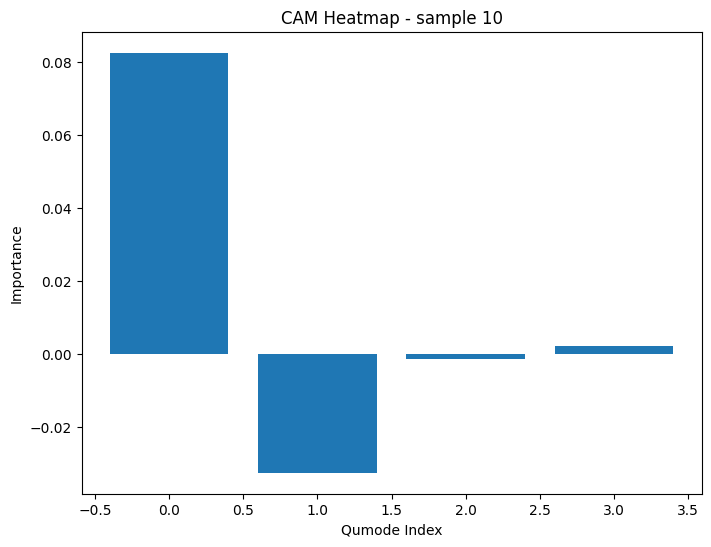

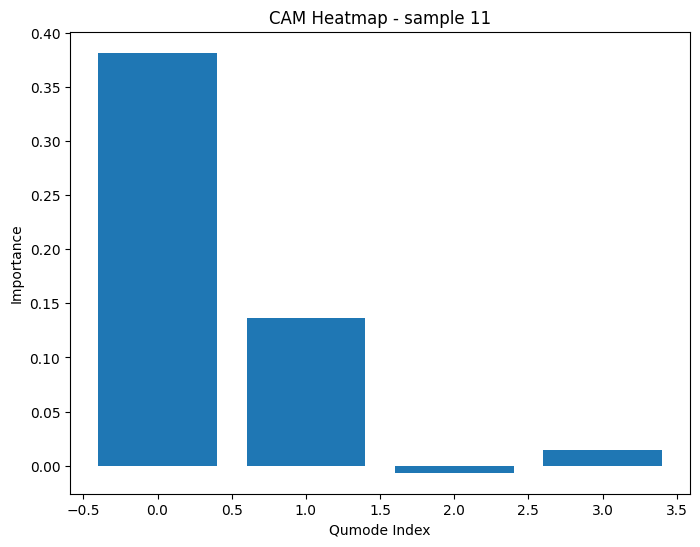

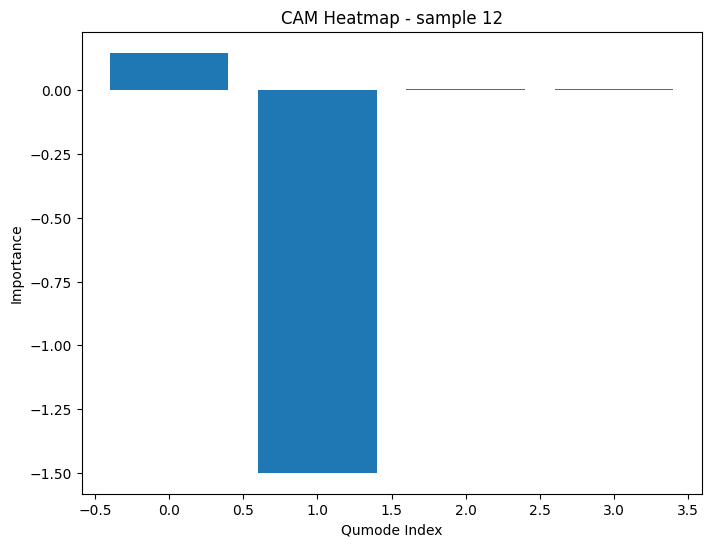

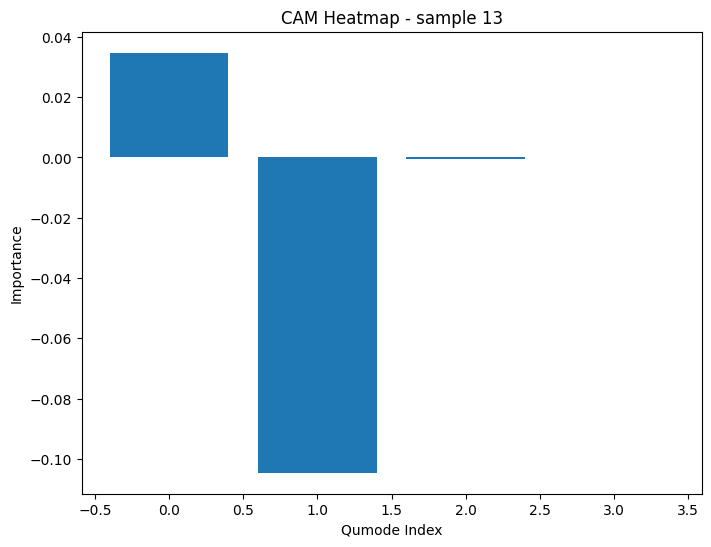

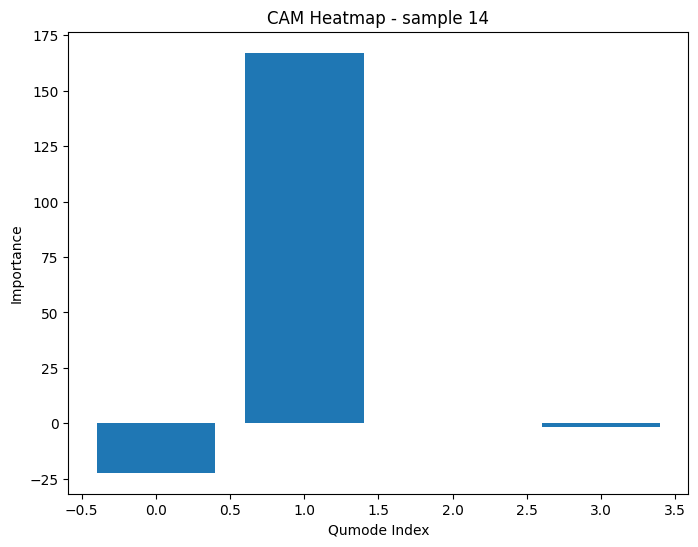

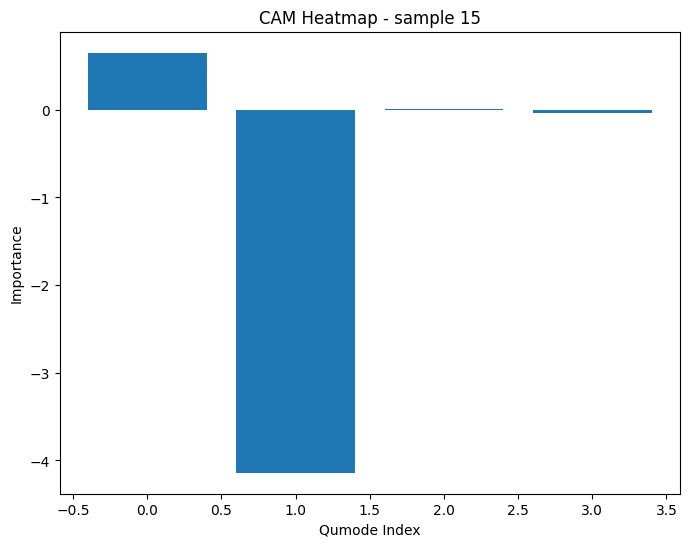

In [130]:
plot_cam(cam)

In [131]:
components = encoder.pca.components_

In [132]:
x_batch, y_batch = sample_batch(test_raw_loader, n_samples=8)

/tmp/ipykernel_15928/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


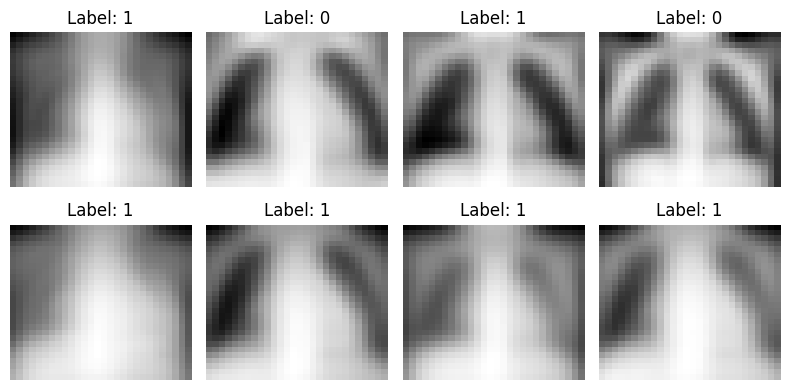

In [133]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

In [134]:
heatmap_image_space = torch.matmul(cam, torch.tensor(components))
heatmap_image_space = heatmap_image_space.view(-1, 1, 28, 28)

In [135]:
heatmap_image_space -= heatmap_image_space.min()
heatmap_image_space /= heatmap_image_space.max()

In [136]:
# for i in range(0,7):    
#     plt.imshow(x_reconstructed[idx, 0], cmap="gray")
#     plt.imshow(heatmap_image_space[idx, 0], cmap="jet", alpha=0.5)
#     plt.axis("off")
#     plt.show()

In [137]:
def plot_reconstructed_heatmaps_with_predictions(samples, cam, preds, probs, labels, encoder, class_names=None):
    n_samples = samples.shape[0]
    # n_rows, n_cols = 4, 4
    n_rows = (n_samples + 3) // 4
    n_cols = 8
    
    assert n_samples <= n_rows * n_cols, "Too many samples"

    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,12))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2.5* n_rows))

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(n_samples):
        row = i// 4
        col_base = (i % 4) * 2
    
    # for i in range(n_samples):
    #     ax = axes[i // n_cols, i % n_cols]

        reconstructed = encoder.pca.inverse_transform(samples[i].detach().cpu().numpy().reshape(1, -1))
        reconstructed = torch.tensor(reconstructed).view(1, 1, 28, 28)

        heatmap_cam = cam[i].cpu().numpy().reshape(1, -1)
        heatmap_image = encoder.pca.inverse_transform(heatmap_cam)
        heatmap_image = torch.tensor(heatmap_image).view(1, 1, 28, 28)

        img = reconstructed[0, 0].numpy()
        heat = heatmap_image[0, 0].numpy()

        # ax.imshow(img, cmap="gray")
        # ax.imshow(heat, cmap="jet", alpha=0.45)

        pred_label = class_names[preds[i]] if class_names else str(preds[i].item())
        true_label = class_names[labels[i]] if class_names else str(labels[i].item())
        confidence = f"{probs[i][preds[i]]*100:.1f}%"

        ax1 = axes[row, col_base]
        ax1.imshow(img, cmap="gray")
        ax1.set_title(f"GT: {true_label}", fontsize=9)
        ax1.axis("off")

        ax2 = axes[row, col_base + 1]
        ax2.imshow(img, cmap="gray")
        ax2.imshow(heat, cmap="jet", alpha=0.45)
        ax2.set_title(f"Pred: {pred_label} ({confidence})", fontsize=9)
        ax2.axis("off")

        # ax.set_title(f"GT: {true_label} | Pred: {pred_label} ({confidence})", fontsize=10)
        # ax.axis("off")

    plt.tight_layout()
    plt.show()

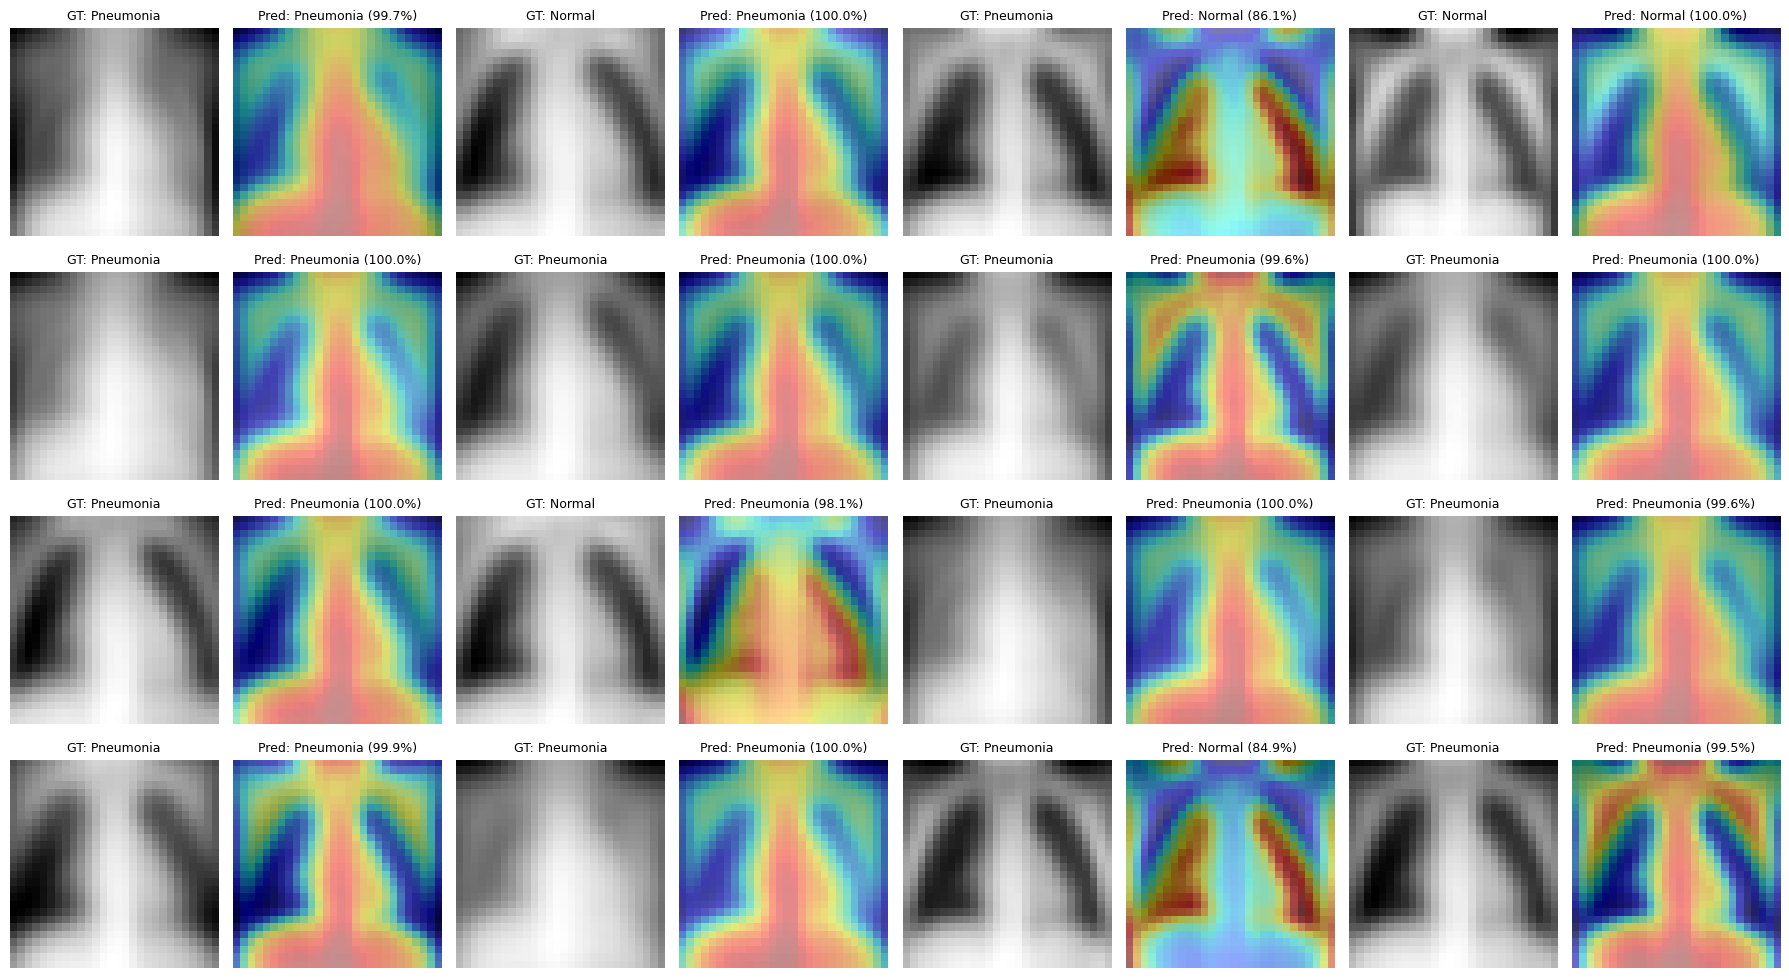

In [138]:
plot_reconstructed_heatmaps_with_predictions(
    samples=samples,
    cam=cam,
    preds=predictions,
    probs=outputs,
    labels=y_sample_labels,
    encoder=encoder,
    class_names=["Normal", "Pneumonia"]
)

In [115]:
# n_samples = len(samples)
# n_cols = 2
# # n_rows = (n_samples + n_cols -1) // n_cols
# n_rows = n_samples

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6,3 * n_rows))

# for i in range(n_samples):
#     reconstructed = encoder.pca.inverse_transform(samples[i].detach().cpu().numpy().reshape(1, -1))
#     reconstructed = torch.tensor(reconstructed).view(28, 28).detach().cpu()

#     heatmap_cam = cam[i].cpu().numpy().reshape(1, -1)
#     heatmap_image = encoder.pca.inverse_transform(heatmap_cam)
#     heatmap_image = torch.tensor(heatmap_image).view(28, 28).detach().cpu()

#     # heatmap_image = (heatmap_image, heatmap_image.min()) / (heatmap_image.max() - heatmap_image.min() + 1e-8)
#     min_val = heatmap_image.min()
#     max_val = heatmap_image.max()
#     denom = (max_val - min_val) + 1e-8

#     if isinstance(min_val, torch.Tensor):
#         min_val = min_val.item()
#     if isinstance(max_val, torch.Tensor):
#         max_val = max_val.item()
#     if isinstance(denom, torch.Tensor):
#         denom = denom.item()

#     heatmap_image = (heatmap_image - min_val) / denom

#     axes[i, 0].imshow(reconstructed, cmap="gray")
#     axes[i, 0].set_title(f"Reconstructed | GT: {y_sample_labels[i].item()}")
#     axes[i, 0].axis("off")

#     axes[i, 1].imshow(reconstructed, cmap="gray")
#     axes[i, 1].imshow(heatmap_image, cmap="jet", alpha=0.5)
#     axes[i, 1].set_title(f"CAM overlay | Pred: {predictions[i].item()}")
#     axes[i, 1].axis("off")


# plt.tight_layout()
# plt.show()

## CLASSICAL MODEL

In [116]:
epochs = 10
# epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
│    └─Softmax: 2-4                      --
Total params: 114
Trainable params: 114
Non-trainable params: 0

In [ ]:
# run_kfold_training(classical_model, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=epochs, seed=42)
run_kfold_training(ClassicalModel, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=epochs, seed=42)

In [117]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

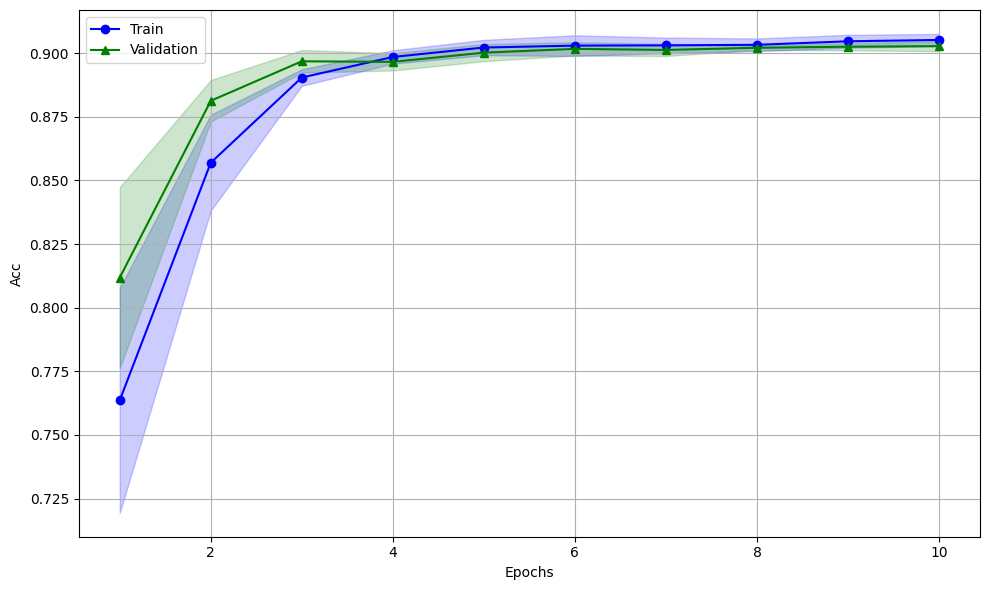

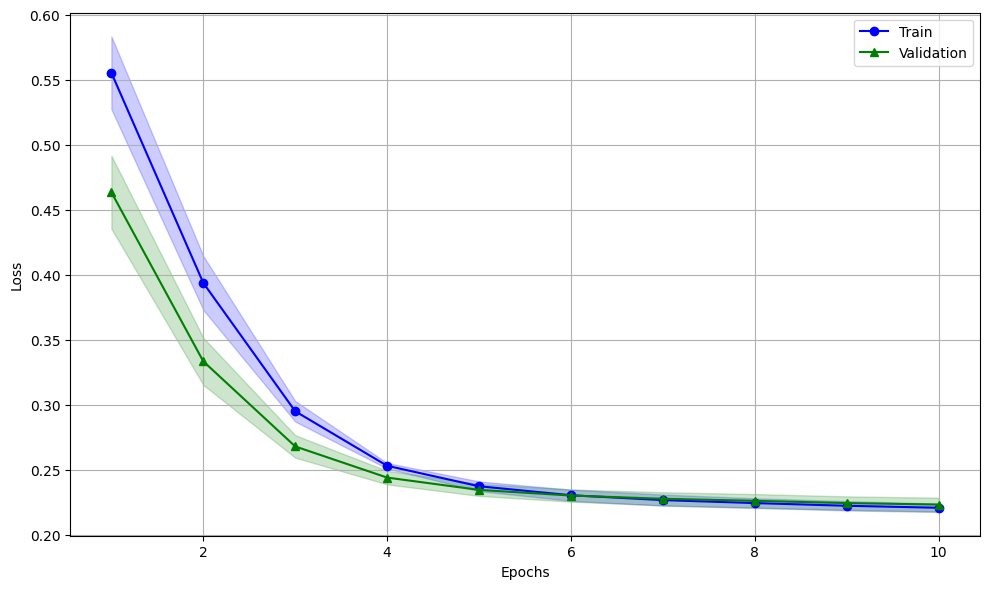

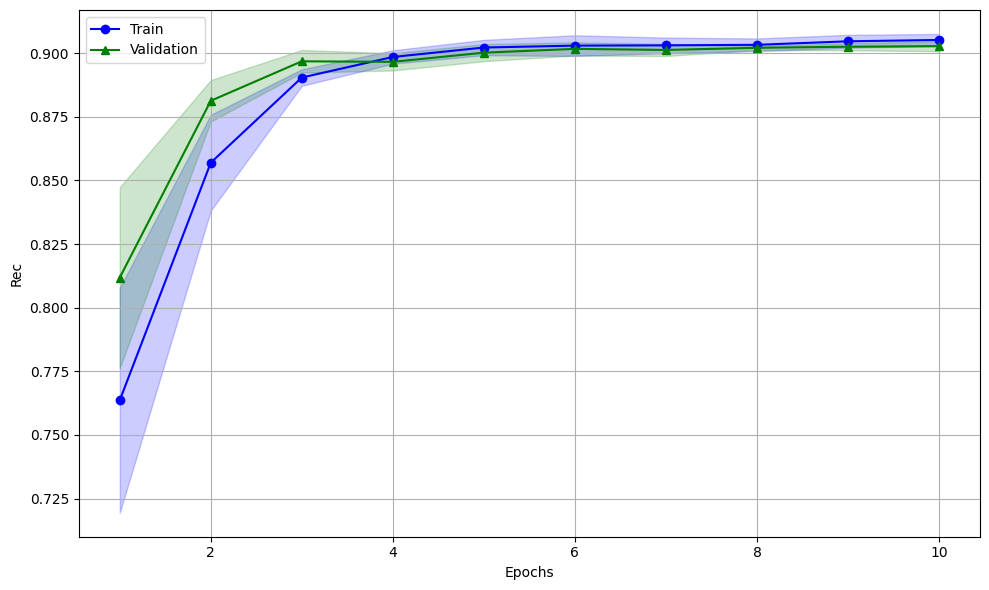

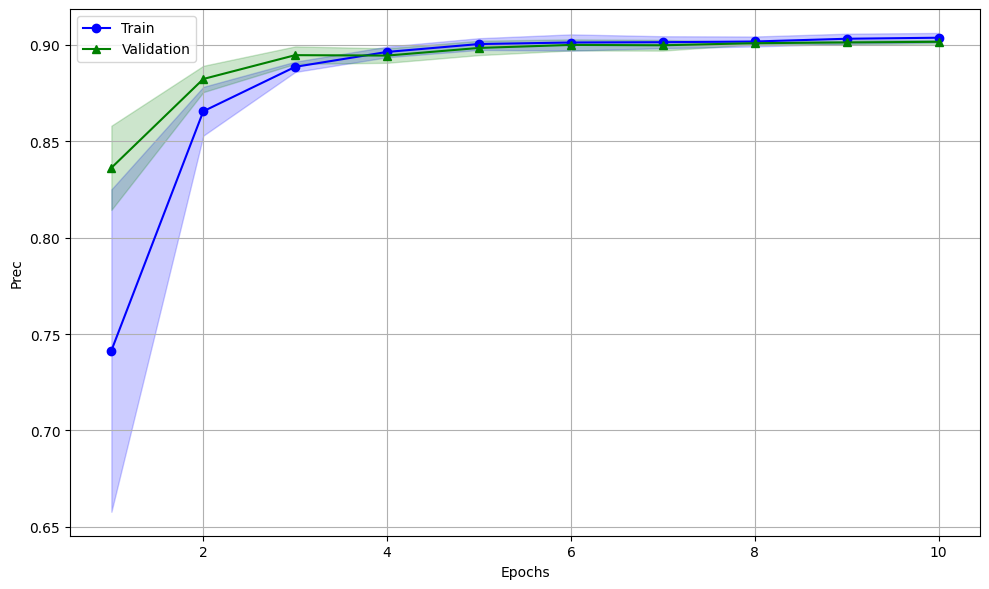

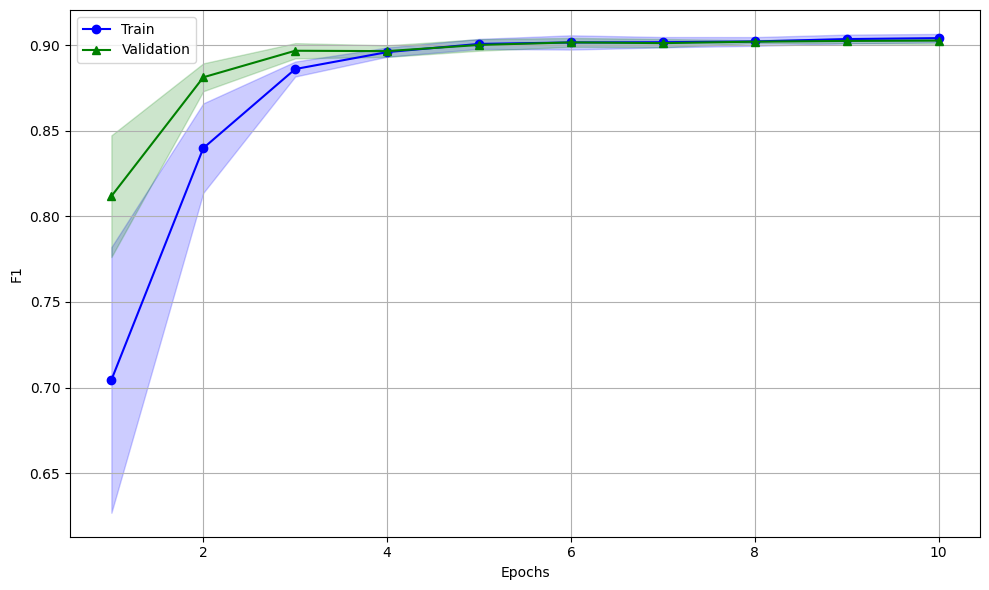

In [118]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range, classical=True, save_name=f"mean_{metric}_curve")
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [ ]:
# c_train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }
# c_val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     # train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
#     train_loss, train_acc, train_prec, train_rec, train_f1, c_train_report = train_v2(classical_model, train_loader, optimizer, criterion, device)
#     # val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, c_val_report, val_preds, val_probs, val_labels = evaluate_v2(classical_model, val_loader, criterion, device)

#     c_train_metrics["acc"].append(train_acc)
#     c_train_metrics["loss"].append(train_loss)
#     c_train_metrics["rec"].append(train_rec)
#     c_train_metrics["prec"].append(train_prec)
#     c_train_metrics["f1"].append(train_f1)
        
#     c_val_metrics["acc"].append(val_acc)
#     c_val_metrics["loss"].append(val_loss)
#     c_val_metrics["rec"].append(val_rec)
#     c_val_metrics["prec"].append(val_prec)
#     c_val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(classical_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth")


#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_train_metrics.json", "w") as f:
#     json.dump(c_train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_val_metrics.json", "w") as f:
#     json.dump(c_val_metrics, f, indent=4)
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

In [ ]:
# epochs = range(1, len(c_train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [119]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 1 with val_f1 = 0.9045


In [120]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
test_classical_model.load_state_dict(torch.load(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{best_fold}_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training: 100%|███████| 20/20 [00:00<00:00, 231.01it/s, loss=0.4713, acc=0.8494]

Test loss: 0.4713 | Test acc: 0.8494 | Test rec: 0.8494 | Test prec: 0.8513 | Test f1: 0.8494


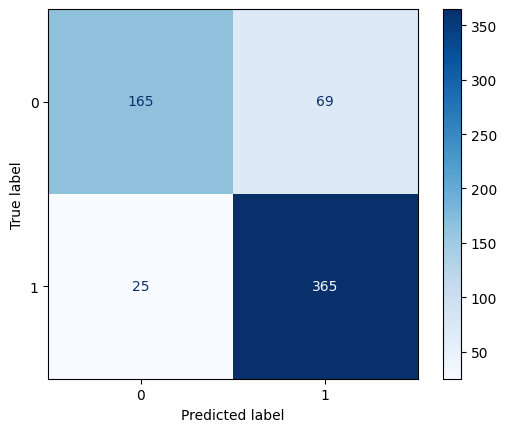

In [121]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-cm", dpi=300)
plt.show()

AUROC: 0.9156585579662503


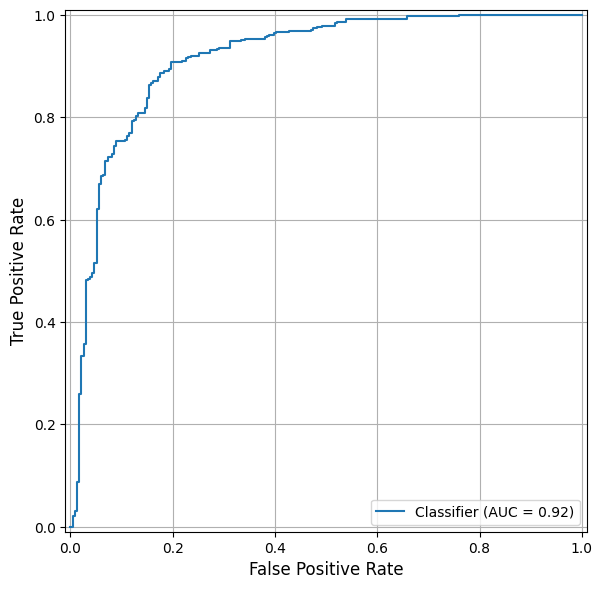

In [122]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1 ])
print("AUROC:", auroc)

fig, ax = plt.subplots(figsize=(8,6))
roc_disp = RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1], ax=ax)

ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-auroc", dpi=300)
plt.show()

# auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
# print("AUROC:", auroc)

# RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
# plt.grid()
# plt.show()

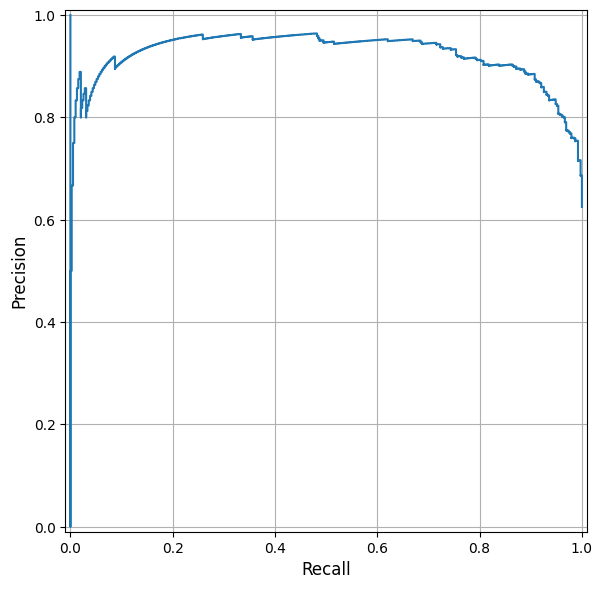

In [123]:
y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

fig, ax = plt.subplots(figsize=(8, 6))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=ax)

# ax.set_title("Precision-Recall Curve", fontsize=14)
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig("/home/dalopezm/quantum-studies/quantum-cv/results/classical-precision_recall_curve", dpi=300)
plt.show()

# y_true = np.array(test_labels)
# y_scores = np.array(test_probs)[:, 1]

# precision, recall, _ = precision_recall_curve(y_true, y_scores)

# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot()
# plt.grid(True)
# plt.show()

In [148]:
cam, outputs, predictions = gradcam_model(test_classical_model, samples, quantum=False)
print(cam.shape)

torch.Size([16, 16])


## DISCRETE VARIABLE MODEL